In [287]:
%matplotlib inline

In [288]:
#export
from exp.nb_02 import *
import torch.nn.functional as Functional

In [289]:
mathPlotLib.rcParams['image.cmap'] = 'plasma'

Data Setup
---

- Make Sure Data is normalized

In [290]:
xTraining,yTraining,xValidation,yValidation = getMnistData()

Make sure that the data is normalized, so that it has $\mu$ = 0 and $\sigma$ = 1

In [291]:
xTraining.mean(), xTraining.std()

(tensor(0.1304), tensor(0.3073))

Totally not normalized, let's fix that

In [292]:
xTrainingNormalized = normalizeVector(xTraining, xTraining.mean(), xTraining.std())

In [293]:
xTrainingNormalized.mean(), xTrainingNormalized.std()

(tensor(-7.6999e-06), tensor(1.))

# \\0/ 
Yay! Normalized!

Model Setup
---


In [294]:
rows, columns = xTrainingNormalized.shape
numberOfClasses = yTraining.max() + 1. # Largest digit to recognize :)
layerOutput = 50

In [295]:
numberOfClasses.item()

10

In [296]:
class DigitRecognitionModel(torch.nn.Module):
    def __init__(self, inputSize, numberOfClasses, layerOutput):
        super().__init__()
        self.layers = [torch.nn.Linear(inputSize, layerOutput), # Take in image vectors, output reduced matrix
                       torch.nn.ReLU(), # Perform activations
                       torch.nn.Linear(layerOutput, numberOfClasses)] # Predict digit classes.
#         self.layers = [layer.cuda() for layer in self.layers]
    def __call__(self, trainingSet):
        layerInput = trainingSet
        for layer in self.layers: layerInput = layer(layerInput)
        return layerInput

In [297]:
digitReconModel = DigitRecognitionModel(columns, numberOfClasses.item(), layerOutput)

In [298]:
digitReconModel.layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [299]:
rawPredictions = digitReconModel(xTrainingNormalized)

In [300]:
rawPredictions.shape

torch.Size([50000, 10])

In [301]:
rawPredictions

tensor([[-0.3872, -0.5327, -0.4959,  ..., -0.1437,  0.2116,  0.4025],
        [-0.2054, -0.4431, -0.3664,  ..., -0.3712,  0.2399,  0.4051],
        [ 0.1426, -0.0157,  0.1514,  ..., -0.0771,  0.2230, -0.0040],
        ...,
        [ 0.0499, -0.0287, -0.3104,  ..., -0.1593,  0.2385,  0.1238],
        [ 0.0585, -0.1225, -0.5098,  ..., -0.0896,  0.0994,  0.4788],
        [ 0.3179,  0.1188, -0.0957,  ..., -0.2139,  0.3013,  0.2271]],
       grad_fn=<AddmmBackward>)

Loss Function
---

### Predictions

Your model has to predict something so that we cat teach it something.

First, we will need to compute the softmax of our **activations**. This is defined by:

$$\hbox{softmax}(\vec{x})_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

Which inturn turns the activations from the last layer into predictions of the probablity of belonging to one of the output classes.

$\hbox{exp}(constant) = e^{constant}$


In [302]:
def softMaxLoss(predictionVector):
    return (predictionVector.exp()/predictionVector.exp().sum(-1, keepdim=True))

In [303]:
predictions = softMaxLoss(rawPredictions)

In [304]:
predictions

tensor([[0.0647, 0.0560, 0.0581,  ..., 0.0826, 0.1178, 0.1426],
        [0.0831, 0.0655, 0.0707,  ..., 0.0704, 0.1297, 0.1530],
        [0.1082, 0.0923, 0.1091,  ..., 0.0868, 0.1172, 0.0934],
        ...,
        [0.0985, 0.0911, 0.0687,  ..., 0.0799, 0.1190, 0.1061],
        [0.1013, 0.0845, 0.0574,  ..., 0.0873, 0.1055, 0.1542],
        [0.1242, 0.1018, 0.0822,  ..., 0.0730, 0.1222, 0.1134]],
       grad_fn=<DivBackward0>)

In [305]:
predictions.sum(-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward2>)

We can see that it outputs a bunch of ones when we sum the softmax vectors together, which is expected :D

*Apparently in practice you have to take the log of soft max to get something useful*

In [306]:
predicitonsLogged = predictions.log()

In [307]:
predicitonsLogged.sum(-1)

tensor([-23.6066, -23.4864, -23.0930,  ..., -23.3039, -23.3799, -23.1664],
       grad_fn=<SumBackward2>)

## Loss
### Entropy Loss

$$ -\sum x\, \log p(x) $$


**Step One: Figure out how to get validation data**

In [308]:
yTraining[96:99]

tensor([7, 8, 3])

These are the digits that each x is supposed to represent lets see!

The 96th is supposed to be a **7**

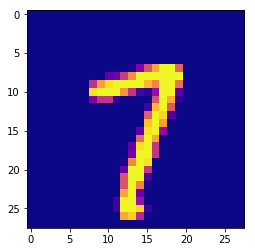

In [309]:
plotter.imshow(xTrainingNormalized[96].cpu().view(28,28))

Well would you look at that, ain't that neat?

Now let's see what our model thought how much this image looked like a **7**

In [310]:
predicitonsLogged[96][6]

tensor(-2.3281, grad_fn=<SelectBackward>)

# 🤔
Looks like it did not do a very good job, let's tell it what it needs to do to fix that

First, let's look at what our range looks like

In [311]:
predicitonsLogged[[96,97,98]]

tensor([[-2.4033, -2.1348, -2.5309, -2.2711, -2.6368, -2.1228, -2.3281, -2.4963,
         -2.2511, -2.0242],
        [-2.5394, -2.5198, -2.9830, -1.9815, -2.4293, -2.2612, -2.4765, -2.7058,
         -1.9408, -1.7998],
        [-2.2056, -2.2809, -2.6385, -2.1681, -2.4669, -2.3054, -2.0655, -2.5011,
         -2.1394, -2.3999]], grad_fn=<IndexBackward>)

Now let's remind ourselves what our expected digits are suppossed to be.

In [312]:
yTraining[96:99]

tensor([7, 8, 3])

**Combine all for profit**

In [313]:
predicitonsLogged[[96,97,98], [7,8,3]]

tensor([-2.4963, -1.9408, -2.1681], grad_fn=<IndexBackward>)

Now we can see what our model's predictions where for each of the digits. And **they are all bad**!

Let's now use this knowlege to perform

$$ -\sum x\, \log p(x) $$


In [314]:
def lossFundie(predictionVector, expectedVector): # expected vector is an array of numbers eg [4, 3, 9, 8] which correspond to each of the output classes.
    items = range(predictionVector.shape[0]) # 0 to 50000 iterator
    return -predictionVector[items, expectedVector].mean()


In [315]:
loss = lossFundie(predicitonsLogged, yTraining)

In [316]:
loss

tensor(2.3218, grad_fn=<NegBackward>)

### Enhanced LogMax!

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [317]:
def logMaxEnhanced(predictions):
    return predictions - predictions.logsumexp(-1, keepdim=True)

In [318]:
predictionsEnhanced = logMaxEnhanced(predicitonsLogged)

In [319]:
testNear(lossFundie(predictionsEnhanced, yTraining), loss)

Now that we have all of the things that we need to tell our model that it is doing a bad job. Now let's move on to teaching it how to be better. The first step there is the 

Training loop
---

In [320]:
realLossFunction = Functional.cross_entropy

In [321]:
batchSize = 64

In [322]:
#export
def accuracy(predictionVector, expectedVector):
    return (torch.argmax(predictionVector, dim=1) == expectedVector).float().mean()

In [323]:
inputBatch = xTrainingNormalized[0:batchSize]
expectedOutputBatch = yTraining[0:batchSize]

In [324]:
predictions = digitReconModel(inputBatch)

In [325]:
predictions.shape, predictions[0]

(torch.Size([64, 10]),
 tensor([-0.3872, -0.5327, -0.4959,  0.3915, -0.0376,  0.3730,  0.1169, -0.1437,
          0.2116,  0.4025], grad_fn=<SelectBackward>))

In [326]:
predictionsSoftMaxed = softMaxLoss(predictions).log()

In [327]:
# The numbers our model guessed
torch.argmax(predictionsEnhanced, dim=1)

tensor([9, 9, 8,  ..., 6, 9, 0])

In [328]:
# The largest prediction levels for each tuple.
predictionsSoftMaxed[range(0, batchSize), torch.argmax(predictionsSoftMaxed, dim=1)]

tensor([-1.9480, -1.8775, -2.1438, -2.0242, -2.0767, -1.7691, -1.9394, -1.8847,
        -1.9641, -2.0388, -2.0140, -2.0925, -2.0549, -2.0589, -2.0535, -1.9882,
        -1.7559, -1.9391, -2.1218, -2.1305, -2.0132, -1.9379, -2.1349, -2.0537,
        -1.5373, -1.7949, -2.0526, -1.9774, -1.7432, -2.0310, -2.0379, -1.7661,
        -1.8911, -1.9774, -1.8800, -2.0218, -1.9286, -1.9246, -1.9899, -1.8869,
        -2.1555, -1.8745, -2.0541, -2.0687, -2.0345, -1.8872, -2.0867, -1.9217,
        -2.0325, -1.9956, -1.9493, -1.9070, -2.0198, -2.0715, -1.9224, -1.9747,
        -1.9991, -2.1033, -1.9085, -2.0083, -2.1535, -1.9370, -2.0715, -1.9119],
       grad_fn=<IndexBackward>)

In [341]:
accuracy(predictions, expectedOutputBatch)

tensor(0.1250)

About as good as random guessing.

# How to train a model

In [332]:
learningRate = 0.5
epochs = 1

### Get ready to train!

In [334]:
for epoch in range(epochs):
    for i in range((rows//batchSize + 1)): # Process each of the batches
        beginningRange = i * batchSize
        endingRange = beginningRange + batchSize
        _inputBatch = xTrainingNormalized[beginningRange:endingRange]
        validationBatch = yTraining[beginningRange:endingRange]
        preds = digitReconModel(_inputBatch)
        loss = realLossFunction(preds, validationBatch)
        
        loss.backward()
        
        with torch.no_grad():
            for layer in digitReconModel.layers:
                if hasattr(layer, 'weight'):
                    layer.weight -= layer.weight.grad * learningRate
                    layer.bias -= layer.bias.grad * learningRate
                    layer.weight.grad.zero_()
                    layer.bias.grad.zero_()


In [337]:
torch.argmax(digitReconModel(inputBatch), dim=1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 3, 4, 3, 7, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        5, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [338]:
expectedOutputBatch

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [340]:
accuracy(digitReconModel(xTrainingNormalized[69:100]), yTraining[69:100])

tensor(0.9355)

Yay! Higher accuracy rates!

**Moving on to refactoring the model to have that enhancement**

In [351]:
class EnhancedDigitModel(torch.nn.Module): 
    def __init__(self, inputSize, numberHiddenLayers, classes):
        super().__init__()
        self.layerOne = torch.nn.Linear(inputSize, numberHiddenLayers)
        self.layerTwo = torch.nn.Linear(numberHiddenLayers, classes)
        
    def __call__(self, inputMatrix): return self.layerTwo(Functional.relu(self.layerOne(inputMatrix)))

In [353]:
enhancedDigitModel = EnhancedDigitModel(columns, layerOutput, numberOfClasses.item())

In [355]:
predictions = enhancedDigitModel(inputBatch)

In [358]:
torch.argmax(predictions, dim=1)

tensor([2, 8, 0, 2, 8, 8, 2, 2, 8, 2, 2, 2, 2, 6, 8, 2, 6, 2, 3, 2, 2, 2, 2, 2,
        2, 8, 8, 2, 2, 8, 2, 2, 6, 2, 8, 2, 2, 8, 8, 8, 8, 8, 8, 2, 2, 8, 2, 8,
        9, 2, 6, 2, 8, 3, 2, 2, 8, 8, 2, 2, 8, 8, 3, 2])

In [359]:
expectedOutputBatch

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [361]:
accuracy(predictions, expectedOutputBatch)

tensor(0.0781)

not very good.

In [363]:
enhancedDigitModel

EnhancedDigitModel(
  (layerOne): Linear(in_features=784, out_features=50, bias=True)
  (layerTwo): Linear(in_features=50, out_features=10, bias=True)
)

In [369]:
for epoch in range(epochs):
    for i in range((rows//batchSize + 1)): # Process each of the batches
        beginningRange = i * batchSize
        endingRange = beginningRange + batchSize
        _inputBatch = xTrainingNormalized[beginningRange:endingRange]
        validationBatch = yTraining[beginningRange:endingRange]
        preds = enhancedDigitModel(_inputBatch)
        loss = realLossFunction(preds, validationBatch)
        
        loss.backward()
        
        with torch.no_grad():
            for layerParameter in enhancedDigitModel.parameters(): 
                layerParameter -= layerParameter.grad * learningRate
            enhancedDigitModel.zero_grad() # method inherited from the nn.Module

In [370]:
accuracy(enhancedDigitModel(inputBatch), expectedOutputBatch)

tensor(0.9375)

Better!

In [373]:
def batchData(iteration):
    beginningRange = iteration * batchSize
    endingRange = beginningRange + batchSize
    _inputBatch = xTrainingNormalized[beginningRange:endingRange]
    validationBatch = yTraining[beginningRange:endingRange]
    return _inputBatch, validationBatch

def trainModel(learningModel):
    for i in range((rows)//batchSize + 1):
        _inputBatch, _expectedBatch = batchData(i)
        _predictions = learningModel(_inputBatch)
        
        loss = realLossFunction(_predictions, _expectedBatch)
        
        
        
        loss.backward()
        
        
        with torch.no_grad():
            for layerParameter in learningModel : layerParameter

In [374]:
realLossFunction(enhancedDigitModel(inputBatch), expectedOutputBatch)

tensor(0.2611, grad_fn=<NllLossBackward>)

AttributeError: 'EnhancedDigitModel' object has no attribute 'backward'